`antman`

In [2]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pysam
import re
import os
import subprocess
import seaborn as sns
import sys
from PIL import Image
from tqdm import tqdm
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
import warnings 
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import ranksums
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

# Load genome
genome_fasta_path = '../genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

# Load transcriptome
tr = load_transcriptome_object("../transcriptome/biroi_transcriptome.pkl")

# Load or_db
or_db = pd.read_excel('../ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

Initializing transcriptomics package
Initializing plotting package


In [3]:
for i, row in tqdm(or_db.iterrows(), total=len(or_db)):
    gene = tr.get_gene(row['gene_name']) 
    if len(gene.transcripts) == 0: 
        continue 
    gene = gene.get_transcript_longest_cds()
    or_db.at[i, 'start'] = gene.get_bounds()[0]
    or_db.at[i, 'end'] = gene.get_bounds()[1]
    or_db.at[i, 'strand'] = gene.strand
    or_db.at[i, 'chr'] = gene.chromosome
    or_db.at[i, 'length'] = len(gene.dna_sequence)

or_db = or_db[~or_db['gene_name'].str.contains('Orco')]
or_db = or_db[~or_db['gene_name'].str.contains('frag')]
or_db = or_db.reset_index(drop=True)
or_db

100%|██████████| 502/502 [00:00<00:00, 2928.58it/s]


,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,length
0,1,Or5-R2,70,1,3',6504395.0,6510987.0,-,Chr1,6593.0
1,1,Or5-Q1,70,2,5',6511625.0,6514800.0,-,Chr1,3176.0
2,1,Or5-Q2,72,4,NaN,10934666.0,10938750.0,+,Chr1,4085.0
3,1,Or5-9E1,73,5,NaN,10980671.0,10984094.0,+,Chr1,3424.0
4,1,Or5-D1,75,6,NaN,16103937.0,16106542.0,-,Chr1,2606.0
...,...,...,...,...,...,...,...,...,...,...
492,12,Or5-L34,3,497,NaN,8805040.0,8807434.0,+,Chr12,2395.0
493,12,Or5-L35,3,498,3',8808087.0,8810716.0,+,Chr12,2630.0
494,12,Or5-9E350,5,499,NaN,12304526.0,12308947.0,+,Chr12,4422.0
495,12,Or5-9E351,6,500,NaN,13227042.0,13237610.0,-,Chr12,10569.0


In [4]:
# Find nested lncRNAs within TAs 
TAs = or_db['tandem_array'].unique()
ta_db = [] 

for ta_ in TAs: 
    TA_genes = or_db.loc[or_db['tandem_array'] == int(ta_)]
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    num_genes = len(TA_genes)
    TA_strand = TA_genes['strand'].value_counts().index[0]
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    
    ta_db.append({'tandem_array': ta_, 
                  'strand': TA_strand, 
                  'chromosome': TA_chromosome, 
                  'start': TA_bounds[0],
                  'end': TA_bounds[1], 
                  'length': TA_bounds[1] - TA_bounds[0],
                'num_genes': num_genes,  
                  })

ta_db = pd.DataFrame(ta_db)
ta_db

,tandem_array,strand,chromosome,start,end,length,num_genes
0,70,-,Chr1,6504395,6514800,10405,2
1,72,+,Chr1,10934666,10938750,4084,1
2,73,+,Chr1,10980671,10984094,3423,1
3,75,-,Chr1,16103937,16106542,2605,1
4,76,+,Chr1,16155704,16158465,2761,1
...,...,...,...,...,...,...,...
68,2,+,Chr12,1503224,1507800,4576,1
69,3,+,Chr12,8696505,8810716,114211,32
70,5,+,Chr12,12304523,12308947,4424,1
71,6,-,Chr12,13227042,13237610,10568,1


In [5]:
# drop TAs with only one gene
ta_db = ta_db[ta_db['num_genes'] > 1].reset_index(drop=True)

In [6]:
def get_coverage_rRNA_depleted(tissue, orientation, chrom, start, end): 
    base_path = '../first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{tissue}_renamed_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]


In [7]:
def get_coverage_polyA_female(sample, orientation, chrom, start, end): 
    base_path = '../JL20240124_FemaleRNAseq_first_of_pair_strand_coverage_chrom_h5'
    # Check that orientation is fwd or rev 
    assert orientation in ['fwd', 'rev'], "Orientation must be 'fwd' or 'rev'"
    # Replace fwd and rev with forward and reverse 
    orientation = 'forward' if orientation == 'fwd' else 'reverse'
    # Get the file path
    file_path = f"{base_path}/{sample}_Aligned.sortedByCoord.out_{orientation}_strand_coverage.h5"

    # Reading data
    with h5py.File(file_path, 'r') as f:
        chr_data = f[chrom][:]
    
    # Checks 
    assert 0 <= start < len(chr_data), "Start index is out of range"
    assert 0 < end <= len(chr_data), "End index is out of range"
    assert start < end, "Start must be less than end"

    # Return the coverage values for the specified range
    return chr_data[start:end]

In [8]:
for i, row in tqdm(ta_db.iterrows(), total=len(ta_db)):
    orientation = 'fwd' if row['strand'] == '+' else 'rev'
    ta_db.at[i, 'rRNA_coverage_sense'] = np.mean(get_coverage_rRNA_depleted('Pupae_S5', orientation, row['chromosome'], row['start'], row['end']))
    ta_db.at[i, 'polyA_coverage_sense'] = np.mean(get_coverage_polyA_female('F1', orientation, row['chromosome'], row['start'], row['end']))
    orientation = 'rev' if row['strand'] == '+' else 'fwd'
    ta_db.at[i, 'rRNA_coverage_antisense'] = np.mean(get_coverage_rRNA_depleted('Pupae_S5', orientation, row['chromosome'], row['start'], row['end']))
    ta_db.at[i, 'polyA_coverage_antisense'] = np.mean(get_coverage_polyA_female('F1', orientation, row['chromosome'], row['start'], row['end']))

ta_db

100%|██████████| 37/37 [00:12<00:00,  3.06it/s]


,tandem_array,strand,chromosome,start,end,length,num_genes,rRNA_coverage_sense,polyA_coverage_sense,rRNA_coverage_antisense,polyA_coverage_antisense
0,70,-,Chr1,6504395,6514800,10405,2,1.906103,0.466410,0.561269,0.001057
1,79,-,Chr1,17883604,17944491,60887,11,3.658285,1.259842,6.110828,0.285299
2,80,-,Chr1,18401037,18422446,21409,4,0.365687,0.000000,0.123686,0.000000
3,81,+,Chr1,18696653,18705584,8931,2,5.230881,1.547195,0.726458,0.213190
4,82,-,Chr1,18737581,18752068,14487,3,1.834817,0.416373,0.257610,0.034514
5,56,-,Chr2,2457195,2491432,34237,4,2.929024,0.583433,1.290212,0.253381
6,57,+,Chr2,3715033,3784804,69771,12,1.081896,0.011953,2.377463,0.380158
7,58,+,Chr2,11004633,11010183,5550,2,0.645225,0.000000,0.761802,0.000000
8,60,-,Chr2,14776801,14812660,35859,3,0.946541,0.150032,24.436878,0.219750
9,62,-,Chr2,16359674,16554585,194911,21,2.670860,0.342120,50.602131,0.199968


In [9]:
ta_db['rRNA_coverage_relative'] = ta_db['rRNA_coverage_antisense'] / ta_db['rRNA_coverage_sense']
ta_db['polyA_coverage_relative'] = ta_db['polyA_coverage_antisense'] / ta_db['polyA_coverage_sense']
ta_db.shape

(37, 13)

In [10]:
print(f"Number of TAs: {ta_db.shape[0]}")

Number of TAs: 37


In [11]:
ta_db_melted = ta_db.melt(id_vars=['tandem_array', 'strand', 'chromosome', 'start', 'end', 'length'],
                          value_vars=['rRNA_coverage_relative', 'polyA_coverage_relative'],
                          var_name='coverage_type', value_name='relative_coverage')
ta_db_melted

,tandem_array,strand,chromosome,start,end,length,coverage_type,relative_coverage
0,70,-,Chr1,6504395,6514800,10405,rRNA_coverage_relative,0.294459
1,79,-,Chr1,17883604,17944491,60887,rRNA_coverage_relative,1.670408
2,80,-,Chr1,18401037,18422446,21409,rRNA_coverage_relative,0.338230
3,81,+,Chr1,18696653,18705584,8931,rRNA_coverage_relative,0.138879
4,82,-,Chr1,18737581,18752068,14487,rRNA_coverage_relative,0.140401
...,...,...,...,...,...,...,...,...
69,17,-,Chr10,12693839,13150935,457096,polyA_coverage_relative,0.364105
70,9,-,Chr11,9778476,9785937,7461,polyA_coverage_relative,0.002947
71,10,+,Chr11,12234278,12251405,17127,polyA_coverage_relative,4.344298
72,11,-,Chr11,13604596,13630121,25525,polyA_coverage_relative,0.130247


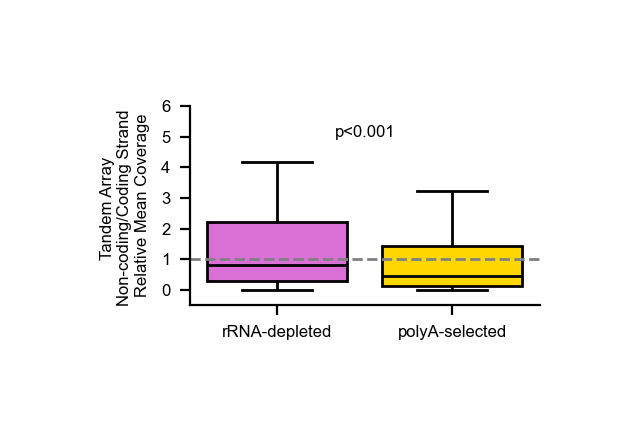

In [21]:
# Plot exon_opp_rel_Pupae_S5 split by overlapping_lncRNA
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5), dpi = 200)

sns.boxplot(data=ta_db_melted, 
            y='relative_coverage', 
            x='coverage_type', 
            palette=['orchid', 'gold'], 
            linecolor='black',
            linewidth=1,
            saturation = 1, 
            fliersize=0,
            ax=ax, 
            order=["rRNA_coverage_relative", "polyA_coverage_relative"])

plt.axhline(y=1, color='grey', linestyle='--', linewidth=1)
plt.ylim(-0.5, 6)
plt.yticks(range(0, 7, 1), fontsize=6)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([0, 1], ['rRNA-depleted', 'polyA-selected'], fontsize=6)
plt.ylabel('Tandem Array \nNon-coding/Coding Strand \nRelative Mean Coverage', fontsize=6)
plt.xlabel('')


# Calculate p-value 
rRNA_coverage_relative = ta_db['rRNA_coverage_relative']
polyA_coverage_relative = ta_db['polyA_coverage_relative']
_, p = ranksums(rRNA_coverage_relative, polyA_coverage_relative)

p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 5, p_value_str, ha='center', fontsize=6)

plt.tight_layout()
plt.savefig(f"../figures/relative_antisense_coverage_rRNA_and_polyA.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()